In [70]:
import numpy as np

In [71]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from pastamarkers import pasta, salsa, add_parmesan
# # Enable better plots
# plt.style.use('ggplot')
# sns.set(font_scale=1.2)
# %matplotlib inline

In [72]:


# ## Define helper functions to extract metadata from filenames

def extract_energy_from_filename(filename):
    """Extract energy value and unit from the filename."""
    match = re.search(r'(\d+)([GMk]?eV)', filename)
    if match:
        return f"{match.group(1)}{match.group(2)}"
    return None

def extract_process_from_filename(filename):
    """Extract the process name from the filename."""
    for process in ["muIoni", "muBrems", "muonNuclear", "muPairProd"]:
        if process in filename:
            return process
    return None

def extract_timestamp_from_filename(filename):
    """Extract timestamp from the filename if available."""
    match = re.search(r'_(\d{8}_\d{6})\.', filename)
    if match:
        return match.group(1)
    return None

# ## Define the main scanning function

def scan_output_directories(base_path="/groups/icecube/jackp/g4mu/output", 
                           pattern="out_*", 
                           recursive=False):
    """
    Scan all directories matching the pattern and collect CSV data.
    Only process newer format files (with energy in filename) to avoid duplicates.
    """
    # Find all directories matching the pattern
    search_path = os.path.join(base_path, pattern)
    if recursive:
        dirs = glob.glob(search_path, recursive=True)
    else:
        dirs = glob.glob(search_path)
    
    print(f"Found {len(dirs)} directories matching the pattern '{pattern}'")
    
    # Initialize storage for different process types
    process_dfs = {
        "muIoni": [],
        "muBrems": [],
        "muonNuclear": [],
        "muPairProd": []
    }
    
    # Process each directory
    for dir_path in sorted(dirs):
        if not os.path.isdir(dir_path):
            continue
            
        dir_name = os.path.basename(dir_path)
        
        # Find all 
        #  files in the directory with the newer naming format
        # Only select files that have energy in the name (secondaries_100000GeV_*)
        csv_files = []
        all_csv_files = glob.glob(os.path.join(dir_path, "secondaries_*.csv"))
        
        # Filter to keep only the newer format files
        for file in all_csv_files:
            filename = os.path.basename(file)
            # Check if it matches the pattern secondaries_XXXGeV_processName_timestamp.csv
            if re.search(r'secondaries_\d+[GMk]?eV_\w+_\d{8}_\d{6}\.csv', filename):
                csv_files.append(file)
        
        # Skip directories with no CSV files
        if not csv_files:
            continue
        
        # Extract energy from directory name as fallback
        dir_energy = None
        energy_match = re.search(r'out_(\d+)([GMk]?eV)', dir_name)
        if energy_match:
            dir_energy = f"{energy_match.group(1)}{energy_match.group(2)}"
        
        # Process each CSV file
        for csv_file in csv_files:
            filename = os.path.basename(csv_file)
            
            # Extract energy from filename
            file_energy = extract_energy_from_filename(filename)
            energy = file_energy if file_energy else dir_energy
            
            # Extract process type
            process = extract_process_from_filename(filename)
            if process:
                # Read the CSV file
                try:
                    df = pd.read_csv(csv_file)
                    
                    # Skip empty dataframes
                    if df.empty:
                        continue
                    
                    # Add metadata columns
                    df['process'] = process
                    df['energy'] = energy
                    df['directory'] = dir_name
                    df['source_file'] = filename
                    
                    # Try to get numeric energy value for sorting
                    energy_val_match = re.search(r'(\d+)', energy) if energy else None
                    if energy_val_match:
                        df['energy_value'] = int(energy_val_match.group(1))
                    else:
                        df['energy_value'] = 0
                    
                    # Add to the appropriate process DataFrame
                    process_dfs[process].append(df)
                    
                    print(f"Added {dir_name}/{filename} ({len(df)} rows)")
                        
                except Exception as e:
                    print(f"Error reading {filename}: {str(e)}")
    
    # Combine all dataframes for each process
    combined_dfs = {}
    for process, df_list in process_dfs.items():
        if df_list:
            combined_dfs[process] = pd.concat(df_list, ignore_index=True)
            print(f"Combined {len(df_list)} files for {process} process, total {len(combined_dfs[process])} rows")
        else:
            print(f"No data found for {process} process")
    
    # Also create an all-processes combined dataframe
    if combined_dfs:
        all_data = pd.concat(combined_dfs.values(), ignore_index=True)
        combined_dfs['all'] = all_data
        print(f"Combined all processes: {len(all_data)} total rows")
    
    return combined_dfs


In [73]:

# ## Scan directories and load the data

# Set the base path to your output directory
base_path = "/groups/icecube/jackp/g4mu/output"

# Scan and load data
dfs = scan_output_directories(base_path=base_path)

# ## Basic Data Exploration

# Check what energies we have in the data
if 'all' in dfs:
    unique_energies = dfs['all']['energy'].unique()
    print(f"\nFound data for {len(unique_energies)} energy values:")
    for energy in sorted(unique_energies, key=lambda x: float(re.search(r'(\d+)', x).group(1)) if re.search(r'(\d+)', x) else 0):
        print(f"  - {energy}")

# ## Summary by Energy and Process

# Get a summary by energy and process
if 'all' in dfs:
    summary = dfs['all'].groupby(['energy', 'process']).agg({
        'sum_of_sec_track_lengths_without_FT_correction [m]': 'mean',
        'sum_of_sec_kin_energies [GeV]': 'mean',
        'muon_track_length [m]': 'mean',
        'directory': 'nunique'
    }).reset_index()
    
    print("\nSummary by energy and process:")
    display(summary)

# ## Data Visualization


Found 105 directories matching the pattern 'out_*'
Added out_100000GeV/secondaries_100000GeV_muBrems_20250407_103236.csv (1 rows)
Added out_100000GeV/secondaries_100000GeV_muPairProd_20250407_103236.csv (1 rows)
Added out_100000GeV/secondaries_100000GeV_muIoni_20250407_103236.csv (1 rows)
Added out_100000GeV/secondaries_100000GeV_muonNuclear_20250407_103236.csv (1 rows)
Added out_100000GeV_10/secondaries_100000GeV_muPairProd_20250407_103315.csv (1 rows)
Added out_100000GeV_10/secondaries_100000GeV_muonNuclear_20250407_103315.csv (1 rows)
Added out_100000GeV_10/secondaries_100000GeV_muIoni_20250407_103315.csv (1 rows)
Added out_100000GeV_10/secondaries_100000GeV_muBrems_20250407_103315.csv (1 rows)
Added out_100000GeV_10m_prop/secondaries_100000GeV_muonNuclear_20250407_103446.csv (1 rows)
Added out_100000GeV_10m_prop/secondaries_100000GeV_muBrems_20250407_103446.csv (1 rows)
Added out_100000GeV_10m_prop/secondaries_100000GeV_muPairProd_20250407_103446.csv (1 rows)
Added out_100000GeV_10

,energy,process,sum_of_sec_track_lengths_without_FT_correction [m],sum_of_sec_kin_energies [GeV],muon_track_length [m],directory
0,100000GeV,muBrems,2.468642e-01,5.083473e-02,545.454545,11
1,100000GeV,muIoni,1.684309e+02,4.186410e+01,545.454545,11
2,100000GeV,muPairProd,6.510884e+01,2.305961e+01,545.454545,11
3,100000GeV,muonNuclear,1.429032e+01,2.797329e+00,545.454545,11
4,10000GeV,muBrems,1.882544e-01,6.801517e-02,954.545461,11
5,10000GeV,muIoni,2.796181e+02,6.630865e+01,954.545461,11
6,10000GeV,muPairProd,9.570236e+01,3.579685e+01,954.545461,11
7,10000GeV,muonNuclear,5.716304e+02,2.185351e+00,954.545461,11
8,1000GeV,muBrems,2.019202e-01,6.408616e-02,822.581034,13
9,1000GeV,muIoni,2.347415e+02,5.581957e+01,822.581034,13


In [74]:
dfs['all']

,sum_of_sec_track_lengths_without_FT_correction [m],sum_of_sec_track_lengths_with_FT_correction [m],sum_of_sec_kin_energies [GeV],muon_kinetic_energy [GeV],muon_track_length [m],num_photons_lowE_sec,num_photons_muon,total_num_photons,event_id,process,energy,directory,source_file,energy_value
0,154.970252,140.906845,38.454257,100000.0,500.0,0.0,0.0,0.0,icesim_E100000000_100000.0_GeV.root_0,muIoni,100000GeV,out_100000GeV,secondaries_100000GeV_muIoni_20250407_103236.csv,100000
1,154.970252,140.906845,38.454257,100000.0,500.0,0.0,0.0,0.0,icesim_E100000000_100000.0_GeV.root_0,muIoni,100000GeV,out_100000GeV_10,secondaries_100000GeV_muIoni_20250407_103315.csv,100000
2,303.037122,274.990421,75.962518,100000.0,1000.0,0.0,0.0,0.0,icesim_E100000000_100000.0_GeV.root_0,muIoni,100000GeV,out_100000GeV_10m_prop,secondaries_100000GeV_muIoni_20250407_103446.csv,100000
3,154.970252,140.906845,38.454257,100000.0,500.0,0.0,0.0,0.0,icesim_E100000000_100000.0_GeV.root_0,muIoni,100000GeV,out_100000GeV_2,secondaries_100000GeV_muIoni_20250407_103526.csv,100000
4,154.970252,140.906845,38.454257,100000.0,500.0,0.0,0.0,0.0,icesim_E100000000_100000.0_GeV.root_0,muIoni,100000GeV,out_100000GeV_3,secondaries_100000GeV_muIoni_20250407_103607.csv,100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8363,63.063988,61.829198,24.122935,500000.0,500.0,0.0,0.0,0.0,icesim_E500000000_500000.0_GeV.root_0,muPairProd,500000GeV,out_500000GeV_4,secondaries_500000GeV_muPairProd_20250408_0010...,500000
8364,63.063988,61.829198,24.122935,500000.0,500.0,0.0,0.0,0.0,icesim_E500000000_500000.0_GeV.root_0,muPairProd,500000GeV,out_500000GeV_5,secondaries_500000GeV_muPairProd_20250408_0012...,500000
8365,63.063988,61.829198,24.122935,500000.0,500.0,0.0,0.0,0.0,icesim_E500000000_500000.0_GeV.root_0,muPairProd,500000GeV,out_500000GeV_6,secondaries_500000GeV_muPairProd_20250408_0014...,500000
8366,63.063988,61.829198,24.122935,500000.0,500.0,0.0,0.0,0.0,icesim_E500000000_500000.0_GeV.root_0,muPairProd,500000GeV,out_500000GeV_7,secondaries_500000GeV_muPairProd_20250408_0016...,500000


In [75]:
dfs['all'].columns

Index(['sum_of_sec_track_lengths_without_FT_correction [m]',
       'sum_of_sec_track_lengths_with_FT_correction [m]',
       'sum_of_sec_kin_energies [GeV]', 'muon_kinetic_energy [GeV]',
       'muon_track_length [m]', 'num_photons_lowE_sec', 'num_photons_muon',
       'total_num_photons', 'event_id', 'process', 'energy', 'directory',
       'source_file', 'energy_value'],
      dtype='object')

In [76]:
np.argmax(np.array(dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]']))

np.int64(4203)

In [77]:
dfs['all'].iloc[265]

sum_of_sec_track_lengths_without_FT_correction [m]                                        288.658924
sum_of_sec_track_lengths_with_FT_correction [m]                                           261.516803
sum_of_sec_kin_energies [GeV]                                                              70.617972
muon_kinetic_energy [GeV]                                                                     1000.0
muon_track_length [m]                                                                    1000.000347
num_photons_lowE_sec                                                                             0.0
num_photons_muon                                                                                 0.0
total_num_photons                                                                                0.0
event_id                                                          icesim_E1000000_1000.0_GeV.root_42
process                                                                                    

In [78]:
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']
track_ratios = np.array(dfs['all']['track_length_ratio'])
np.max(track_ratios), np.argmax(track_ratios)

(np.float64(0.6427198938165217), np.int64(4537))

In [79]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Calculate the ratio of interest for each process
# dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# # Create a scatter plot
# plt.figure(figsize=(10, 6))

# # Define colors for each process type
# colors = {
#     'muIoni': 'blue',
#     'muBrems': 'green',
#     'muonNuclear': 'red',
#     'muPairProd': 'purple'
# }

# # Plot each process as a different color
# for process, color in colors.items():
#     process_data = dfs['all'][dfs['all']['process'] == process]
#     plt.scatter(
#         process_data['energy_value'],  # x-axis: energy
#         process_data['track_length_ratio'],  # y-axis: the ratio
#         c=color,
#         label=process,
#         alpha=0.7,  # slight transparency
#         s=10  # point size
#     )

# # Calculate the sum of ratios for each energy value and directory
# # First, group by energy_value and directory to get the sums
# sum_ratios = dfs['all'].groupby(['energy_value', 'directory'])['track_length_ratio'].sum().reset_index()

# # Plot the sum as a fifth type of point
# trk_r_sum = np.array(sum_ratios['track_length_ratio'])
# print(np.max(trk_r_sum), np.argmax(trk_r_sum))
# plt.scatter(
#     sum_ratios['energy_value'],
#     sum_ratios['track_length_ratio'],
#     c='black',
#     label='All Processes (Sum)',
#     marker='o',  # Star marker to make it stand out
#     alpha=0.9,
#     s=30  # Larger size for visibility
# )

# # Add labels and legend
# plt.xlabel('Energy (GeV)', fontsize=12)
# plt.ylabel('Ratio: Secondary Track Length (with FT) / Muon Track Length', fontsize=12)
# plt.title('Secondary to Muon Track Length Ratio by Process Type', fontsize=14)
# plt.xscale('log')  # log scale for energy
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

In [80]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Calculate the ratio of interest for each process
# dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# # Create a scatter plot
# plt.figure(figsize=(10, 6))


# # Define colors for each process type
# colors = {
#     'muIoni': 'blue',
#     'muBrems': 'green',
#     'muonNuclear': 'red',
#     'muPairProd': 'purple'
# }

# # Plot each process as a different color
# for process, color in colors.items():
#     process_data = dfs['all'][dfs['all']['process'] == process]
#     plt.scatter(
#         process_data['energy_value'],  # x-axis: energy
#         process_data['track_length_ratio'],  # y-axis: the ratio
#         c=color,
#         label=process,
#         alpha=0.7,  # slight transparency
#         s=10  # point size
#     )

# # Calculate the sum of ratios for each energy value and directory
# # First, group by energy_value and directory to get the sums
# sum_ratios = dfs['all'].groupby(['energy_value', 'directory'])['track_length_ratio'].sum().reset_index()

# # # Plot the sum as a fifth type of point
# # plt.scatter(
# #     sum_ratios['energy_value'],
# #     sum_ratios['track_length_ratio'],
# #     c='black',
# #     label='All Processes (Sum)',
# #     marker='o',  # Star marker to make it stand out
# #     alpha=0.9,
# #     s=30  # Larger size for visibility
# # )


# Es = np.linspace(1, 1e6, 10000)
# leif_model = 0.0206*np.log(Es) + .188
# tania_model = .0581*np.log(Es)**.54 + 0.125

# plt.plot(Es, leif_model, label='leif model')
# plt.plot(Es, tania_model, label='tania model')


# # Add labels and legend
# plt.xlabel('Energy (GeV)', fontsize=12)
# plt.ylabel('Total Sec Track / Muon Track', fontsize=12)
# plt.title('Sec Track Ratio by Process Type', fontsize=14)
# plt.xscale('log')  # log scale for energy
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

Maximum total ratio: 1.0055786302454128 and index: 1967


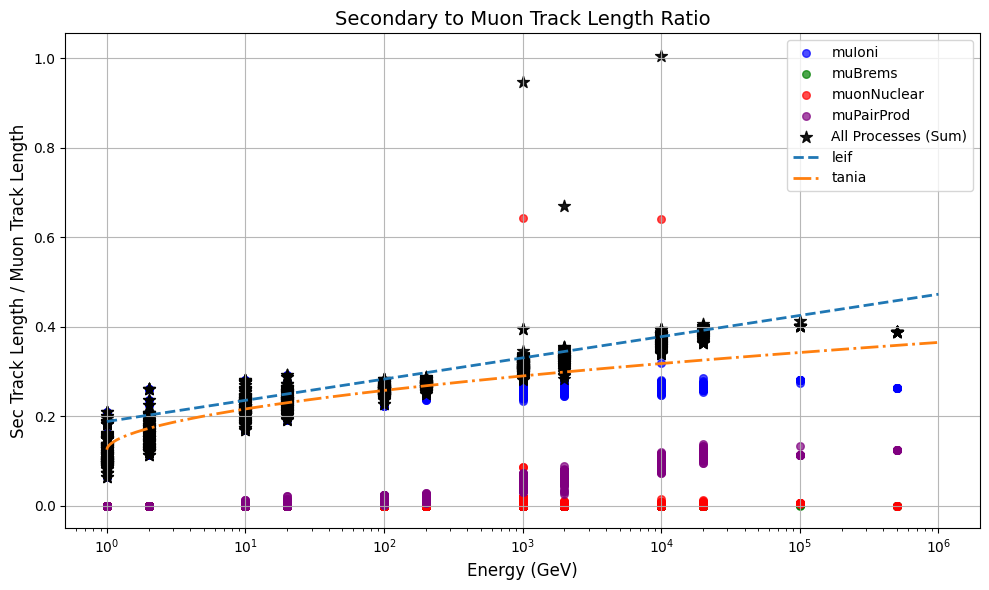

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate the ratio of interest for each process
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],  # x-axis: energy
        process_data['track_length_ratio'],  # y-axis: the ratio
        c=color,
        label=process,
        alpha=0.7,
        s=30  # point size
    )

# Here's the correct approach for the sum:
# We need to calculate the sum of the numerator for all processes at each energy level
# and divide by the same muon track length

# First, let's create a key to identify unique events
dfs['all']['event_key'] = dfs['all']['directory'] + '_' + dfs['all']['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = dfs['all'].groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = dfs['all'].groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} and index: {np.argmax(merged_data['total_ratio'])}")

# Plot the sum as a fifth type of point
plt.scatter(
    merged_data['energy_value'],
    merged_data['total_ratio'],
    c='black',
    label='All Processes (Sum)',
    marker='*',
    alpha=0.9,
    s=80  # Larger size for visibility
)


def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')


# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.9)

plt.tight_layout()
plt.show()

## with fixed y axis:

Maximum total ratio: 1.0055786302454128 and index: 1967


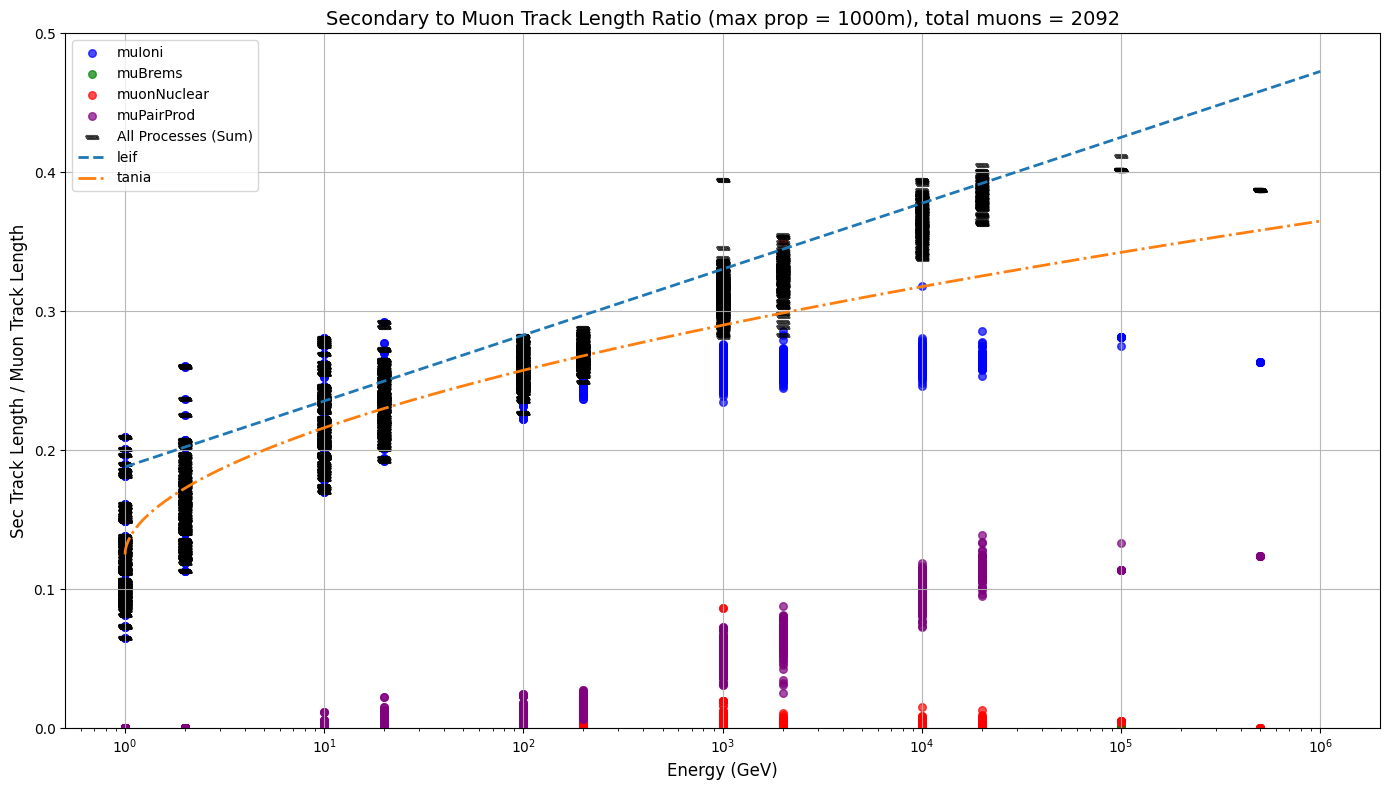

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate the ratio of interest for each process
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(14, 8))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],  # x-axis: energy
        process_data['track_length_ratio'],  # y-axis: the ratio
        c=color,
        label=process,
        alpha=0.7,
        s=30  # point size
    )

# Here's the correct approach for the sum:
# We need to calculate the sum of the numerator for all processes at each energy level
# and divide by the same muon track length

# First, let's create a key to identify unique events
dfs['all']['event_key'] = dfs['all']['directory'] + '_' + dfs['all']['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = dfs['all'].groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = dfs['all'].groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} and index: {np.argmax(merged_data['total_ratio'])}")

# Plot the sum as a fifth type of point
plt.scatter(
    merged_data['energy_value'],
    merged_data['total_ratio'],
    c='black',
    label='All Processes (Sum)',
    marker=pasta.penne,
    alpha=0.7,
    s=80  # Larger size for visibility
)


def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')


# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (max prop = 1000m), total muons = ' + str(len(merged_data['energy_value'])), fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.9)
plt.ylim(0,0.5)

plt.tight_layout()
plt.savefig('prop_1000m.pdf')
plt.show()

Maximum total ratio: 1.0055786302454128 and index: 1967


/tmp/ipykernel_979054/946027032.py:80: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


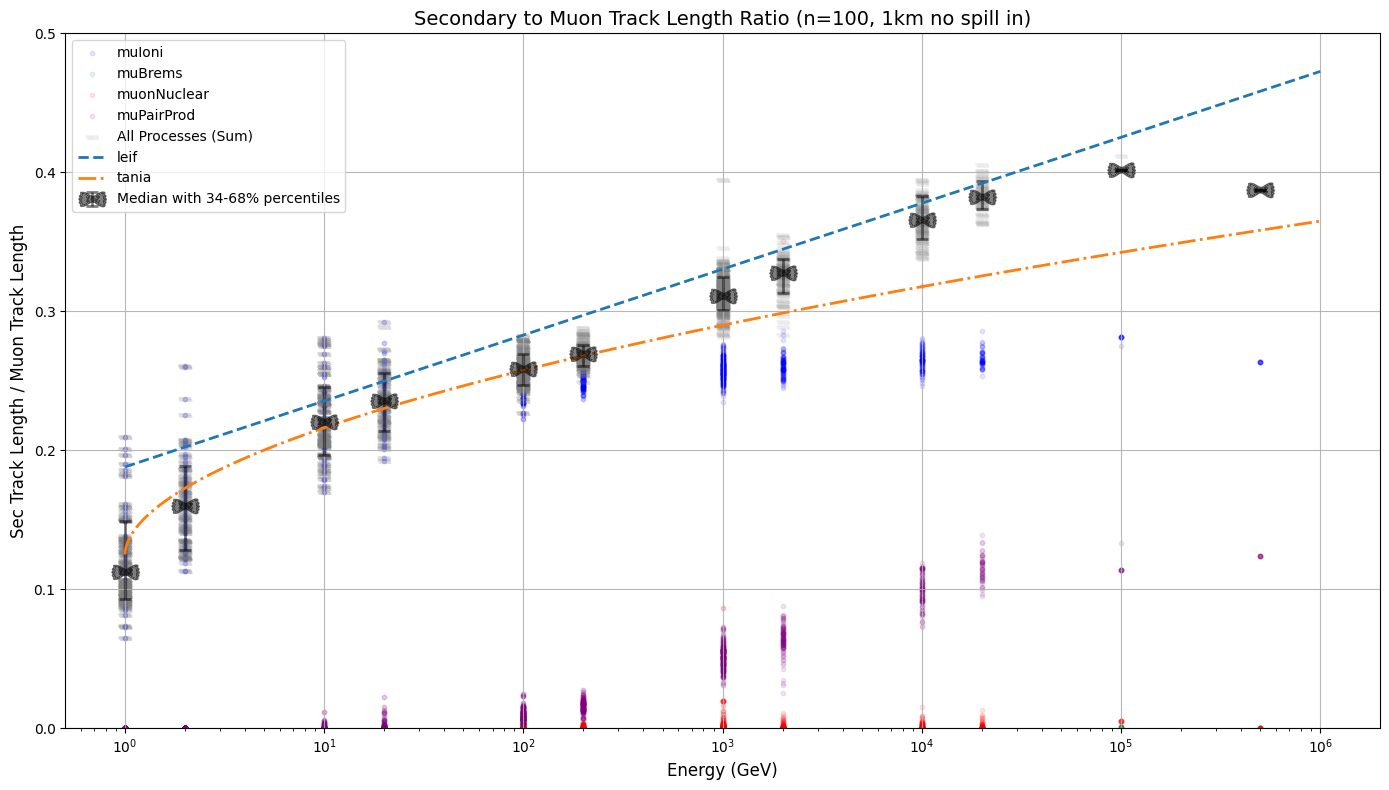

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Calculate the ratio of interest for each process
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(14, 8))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}



# Plot each process as a different color
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],  # x-axis: energy
        process_data['track_length_ratio'],  # y-axis: the ratio
        c=color,
        label=process,
        alpha=0.1,
        s=10  # point size
    )

# Create a key to identify unique events
dfs['all']['event_key'] = dfs['all']['directory'] + '_' + dfs['all']['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = dfs['all'].groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = dfs['all'].groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} and index: {np.argmax(merged_data['total_ratio'])}")

# Instead of plotting individual points, we'll calculate medians and percentiles by energy
energy_grouped = merged_data.groupby('energy_value')

# Calculate median and percentiles for each energy group
medians = []
lower_errors = []
upper_errors = []
energy_vals = []

for energy, group in energy_grouped:
    # Only include groups with enough data points
    if len(group) >= 3:  # Require at least 3 points for meaningful statistics
        median = group['total_ratio'].median()
        p34 = np.percentile(group['total_ratio'], 16)
        p68 = np.percentile(group['total_ratio'], 84)
        
        medians.append(median)
        lower_errors.append(median - p34)
        upper_errors.append(p68 - median)
        energy_vals.append(energy)

# Convert to numpy arrays for easier handling
medians = np.array(medians)
lower_errors = np.array(lower_errors)
upper_errors = np.array(upper_errors)
energy_vals = np.array(energy_vals)

# Plot medians with error bars
plt.errorbar(
    energy_vals,
    medians,
    yerr=[lower_errors, upper_errors],
    fmt='ko',  # Black circles
    capsize=4,
    marker=pasta.farfalle,
    label='Median with 34-68% percentiles',
    markersize=20,
    alpha=0.5,
    elinewidth=2,
    capthick=2
)
plt.scatter(
    merged_data['energy_value'],
    merged_data['total_ratio'],
    c='grey',
    label='All Processes (Sum)',
    marker=pasta.penne,
    alpha=0.1,
    s=80  # Larger size for visibility
)
# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')

# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (n=100, 1km no spill in)', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.tight_layout()
#plt.savefig('prop_1km_farfalle.pdf')
plt.show()

Number of points per energy value:
Energy: 1 GeV - 300 points
Energy: 2 GeV - 200 points
Energy: 10 GeV - 300 points
Energy: 20 GeV - 200 points
Energy: 100 GeV - 300 points
Energy: 200 GeV - 200 points
Energy: 1000 GeV - 310 points
Energy: 2000 GeV - 100 points
Energy: 10000 GeV - 110 points
Energy: 20000 GeV - 52 points
Energy: 100000 GeV - 11 points
Energy: 500000 GeV - 9 points


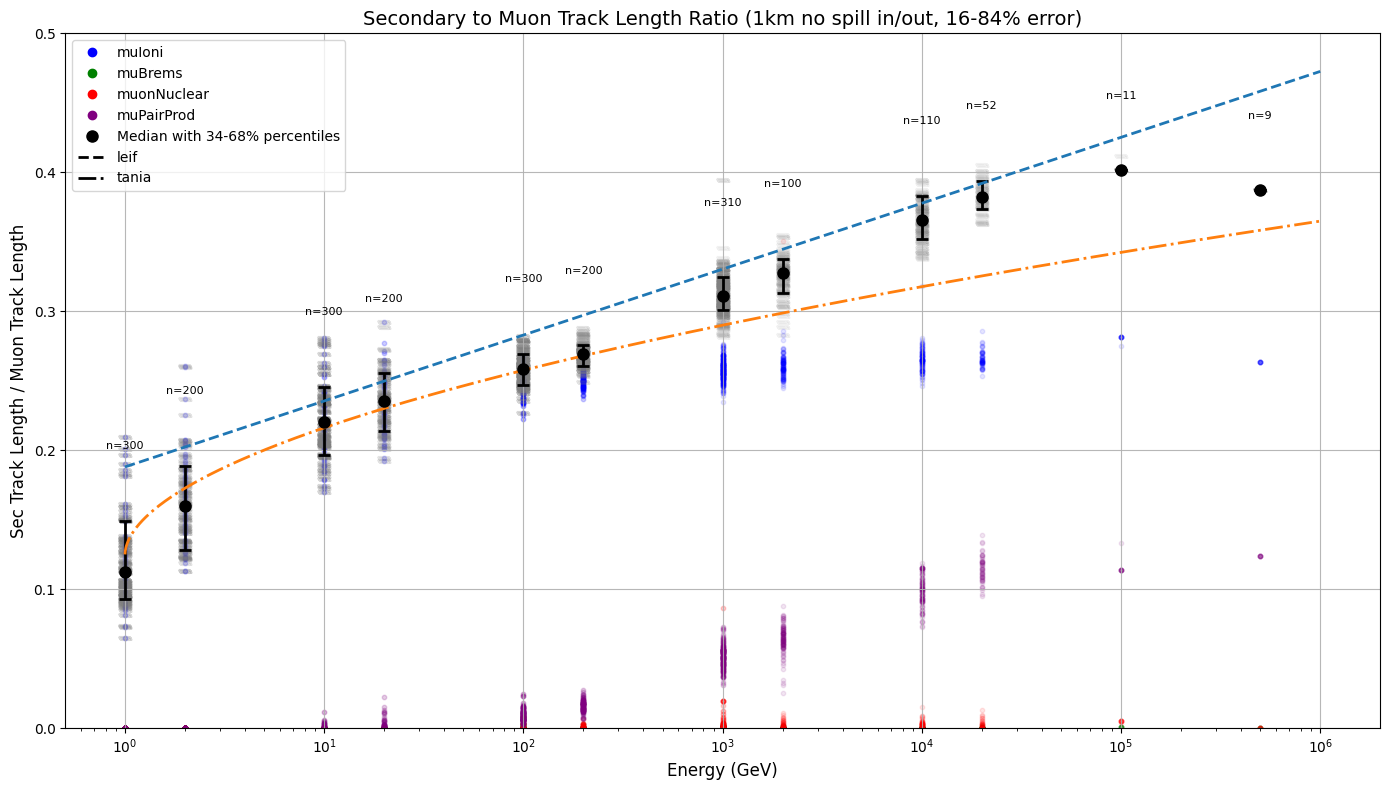

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D

# Your existing code for creating the scatter plot
plt.figure(figsize=(14, 8))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Count and print the number of points per energy value
energy_counts = merged_data['energy_value'].value_counts().sort_index()
print("Number of points per energy value:")
for energy, count in energy_counts.items():
    print(f"Energy: {energy} GeV - {count} points")

# Plot each process as a different color (don't include label here)
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],
        process_data['track_length_ratio'],
        c=color,
        alpha=0.1,
        s=10  # point size
    )

# Create custom legend handles with full opacity
legend_handles = []
for process, color in colors.items():
    handle = Line2D([], [], color=color, marker='o', linestyle='None',
                   markersize=6, label=process)
    legend_handles.append(handle)

# Plot medians with error bars
plt.errorbar(
    energy_vals,
    medians,
    yerr=[lower_errors, upper_errors],
    fmt='ko',
    capsize=4,
    markersize=8,
    elinewidth=2,
    capthick=2
)

# Add an entry for the error bars to the legend handles
error_bar_handle = Line2D([], [], color='black', marker='o', linestyle='None',
                         markersize=8, label='Median with 34-68% percentiles')
legend_handles.append(error_bar_handle)

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

# Add the model lines to legend handles
model1_line = Line2D([], [], color='black', linestyle='--', linewidth=2, label='leif')
model2_line = Line2D([], [], color='black', linestyle='-.', linewidth=2, label='tania')
legend_handles.append(model1_line)
legend_handles.append(model2_line)
plt.scatter(
    merged_data['energy_value'],
    merged_data['total_ratio'],
    c='grey',
    label='All Processes (Sum)',
    marker=pasta.penne,
    alpha=0.1,
    s=80  # Larger size for visibility
)
plt.plot(energies, model1_values, linewidth=2, linestyle='--')
plt.plot(energies, model2_values, linewidth=2, linestyle='-.')

# Add sample sizes to the plot
for energy, count in energy_counts.items():
    if energy in energy_vals:
        idx = np.where(energy_vals == energy)[0][0]
        plt.text(energy, medians[idx] + upper_errors[idx] + 0.05, 
                f"n={count}", ha='center', va='bottom', fontsize=8)

# Add the custom legend to the plot with all handles
plt.legend(handles=legend_handles)

# Add labels and other formatting
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (1km no spill in/out, 16-84% error)', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('prop_5k_error_bars.pdf')
plt.show()

Number of points per energy value:
Energy: 1 GeV - 300 points
Energy: 2 GeV - 200 points
Energy: 10 GeV - 300 points
Energy: 20 GeV - 200 points
Energy: 100 GeV - 300 points
Energy: 200 GeV - 200 points
Energy: 1000 GeV - 310 points
Energy: 2000 GeV - 100 points
Energy: 10000 GeV - 110 points
Energy: 20000 GeV - 52 points
Energy: 100000 GeV - 11 points
Energy: 500000 GeV - 9 points


/tmp/ipykernel_979054/127114846.py:55: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


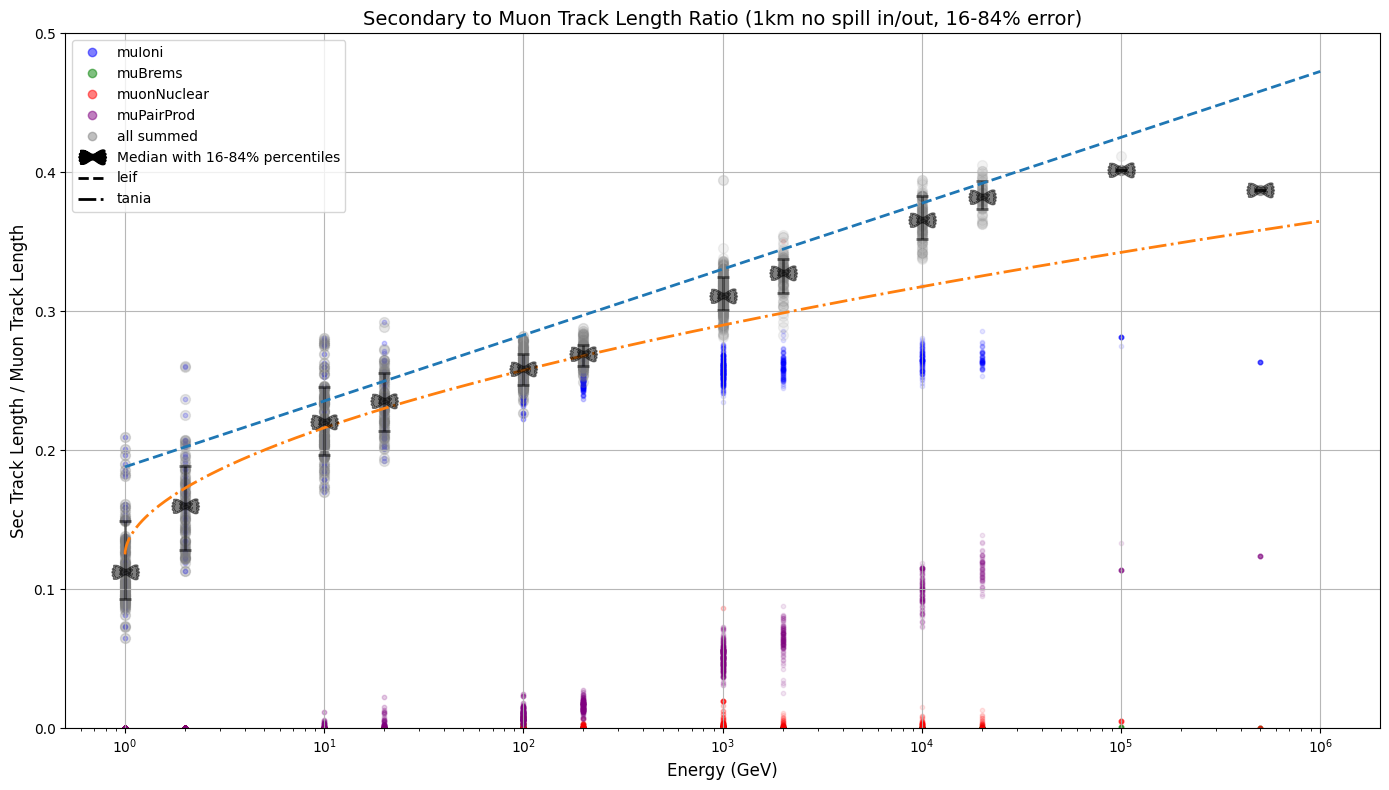

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D

# Create the scatter plot
plt.figure(figsize=(14, 8))

# Filter data for energy < 1e5
filtered_data = merged_data[merged_data['energy_value'] < 1e7]
filtered_dfs_all = dfs['all'][dfs['all']['muon_kinetic_energy [GeV]'] < 1e7]

# Filter arrays for medians and error bars
energy_mask = energy_vals < 1e5
filtered_energy_vals = energy_vals[energy_mask]
filtered_medians = medians[energy_mask]
filtered_lower_errors = lower_errors[energy_mask]
filtered_upper_errors = upper_errors[energy_mask]

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple',
    'all summed': 'grey'
}

# Count and print the number of points per energy value
energy_counts = filtered_data['energy_value'].value_counts().sort_index()
print("Number of points per energy value:")
for energy, count in energy_counts.items():
    print(f"Energy: {energy} GeV - {count} points")

# Plot each process as a different color (don't include label here)
for process, color in colors.items():
    process_data = filtered_dfs_all[filtered_dfs_all['process'] == process]
    plt.scatter(
        process_data['energy_value'],
        process_data['track_length_ratio'],
        c=color,
        alpha=0.1,
        s=10  # point size
    )

# Create custom legend handles with full opacity
legend_handles = []
for process, color in colors.items():
    handle = Line2D([], [], color=color, marker='o', linestyle='None',
                   markersize=6, alpha=0.5,label=process)
    legend_handles.append(handle)

# Plot medians with error bars
plt.errorbar(
    energy_vals,
    medians,
    yerr=[lower_errors, upper_errors],
    fmt='ko',  # Black circles
    capsize=4,
    marker=pasta.farfalle,
    label='Median with 16-84% percentiles',
    markersize=20,
    alpha=0.5,
    elinewidth=2,
    capthick=2
)

# Add an entry for the error bars to the legend handles
error_bar_handle = Line2D([], [], color='black', marker=pasta.farfalle, linestyle='None',
                         markersize=20, label='Median with 16-84% percentiles')
legend_handles.append(error_bar_handle)

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

# Filter model energy range to match data (< 1e5)
energies = np.logspace(np.log10(1), np.log10(1e6), 5000)
model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

# Add the model lines to legend handles
model1_line = Line2D([], [], color='black', linestyle='--', linewidth=2, label='leif')
model2_line = Line2D([], [], color='black', linestyle='-.', linewidth=2, label='tania')
legend_handles.append(model1_line)
legend_handles.append(model2_line)

# Plot all processes sum (after filtering)
plt.scatter(
    filtered_data['energy_value'],
    filtered_data['total_ratio'],
    c='grey',
    label='All Processes (Sum)',
    marker='o',  # Using standard marker instead of pasta.penne
    alpha=0.1,
    s=50  # Larger size for visibility
)


plt.plot(energies, model1_values, linewidth=2, linestyle='--')
plt.plot(energies, model2_values, linewidth=2, linestyle='-.')

# # Add sample sizes to the plot
# for energy, count in energy_counts.items():
#     if energy in filtered_energy_vals:
#         idx = np.where(filtered_energy_vals == energy)[0][0]
#         plt.text(energy, filtered_medians[idx] + filtered_upper_errors[idx] + 0.05,
#                 f"n={count}", ha='center', va='bottom', fontsize=8)

# Add the custom legend to the plot with all handles
plt.legend(handles=legend_handles)

# Add labels and other formatting
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (1km no spill in/out, 16-84% error)', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('prop_1km_farfalle.pdf')
plt.show()

In [25]:
dfs['all'].columns

Index(['sum_of_sec_track_lengths_without_FT_correction [m]',
       'sum_of_sec_track_lengths_with_FT_correction [m]',
       'sum_of_sec_kin_energies [GeV]', 'muon_kinetic_energy [GeV]',
       'muon_track_length [m]', 'num_photons_lowE_sec', 'num_photons_muon',
       'total_num_photons', 'event_id', 'process', 'energy', 'directory',
       'source_file', 'energy_value', 'track_length_ratio', 'event_key'],
      dtype='object')

Number of points per energy value:
Energy: 1 GeV - 300 points
Energy: 2 GeV - 200 points
Energy: 10 GeV - 300 points
Energy: 20 GeV - 200 points
Energy: 100 GeV - 300 points
Energy: 200 GeV - 200 points
Energy: 1000 GeV - 310 points
Energy: 2000 GeV - 100 points
Energy: 10000 GeV - 110 points
Energy: 20000 GeV - 52 points


IndexError: boolean index did not match indexed array along axis 0; size of axis is 12 but size of corresponding boolean axis is 10

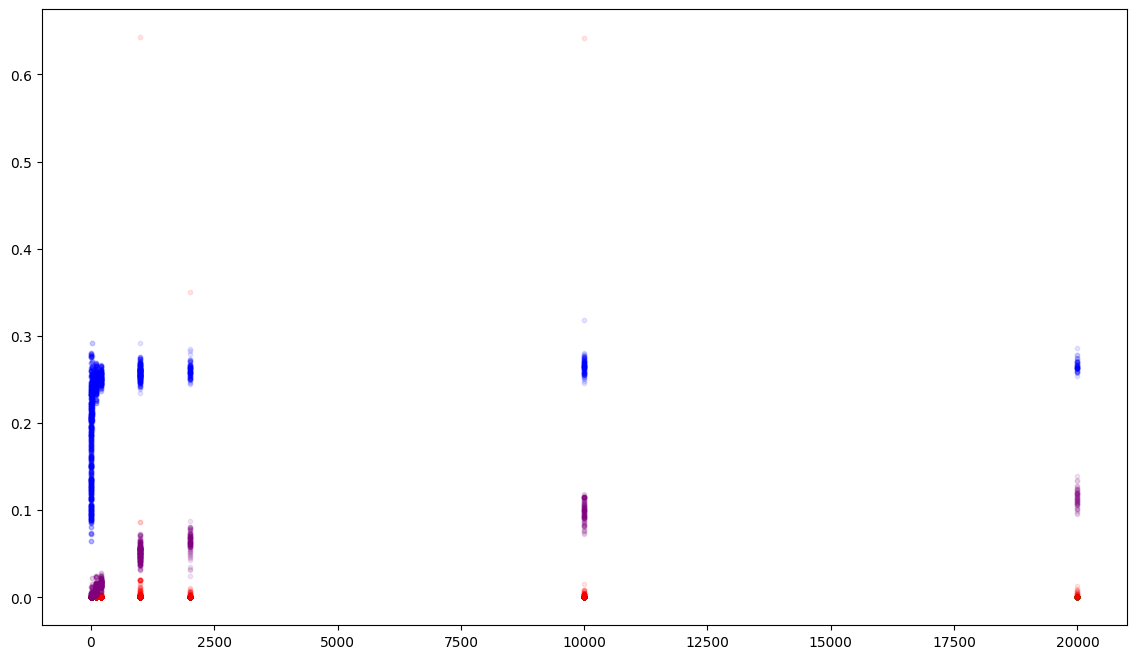

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D
# Filter merged_data to match the energy cutoff
merged_data = merged_data[merged_data['energy_value'] < 1e5]

# Your existing code for creating the scatter plot
plt.figure(figsize=(14, 8))
dfs['all'] = dfs['all'][dfs['all']['muon_kinetic_energy [GeV]'] < 1e5]
# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Count and print the number of points per energy value
energy_counts = merged_data['energy_value'].value_counts().sort_index()
print("Number of points per energy value:")
for energy, count in energy_counts.items():
    print(f"Energy: {energy} GeV - {count} points")

# Plot each process as a different color (don't include label here)
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],
        process_data['track_length_ratio'],
        c=color,
        alpha=0.1,
        s=10  # point size
    )

# Create custom legend handles with full opacity
legend_handles = []
for process, color in colors.items():
    handle = Line2D([], [], color=color, marker='o', linestyle='None',
                   markersize=6, label=process)
    legend_handles.append(handle)

# Plot medians with error bars
idx = energy_vals<1e5
medians = medians[idx]
energy_vals=energy_vals[idx]
lower_errors = lower_errors[idx]
upper_errors = upper_errors[idx]
plt.errorbar(
    energy_vals,
    medians,
    yerr=[lower_errors, upper_errors],
    fmt='ko',  # Black circles
    capsize=4,
    marker=pasta.farfalle,
    label='Median with 34-68% percentiles',
    markersize=20,
    alpha=0.5,
    elinewidth=2,
    capthick=2
)
plt.scatter(
    merged_data['energy_value'],
    merged_data['total_ratio'],
    c='grey',
    label='All Processes (Sum)',
    marker=pasta.penne,
    alpha=0.1,
    s=80  # Larger size for visibility
)
# Add an entry for the error bars to the legend handles
error_bar_handle = Line2D([], [], color='black', marker='o', linestyle='None',
                         markersize=8, label='Median with 34-68% percentiles')
legend_handles.append(error_bar_handle)

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

# Add the model lines to legend handles
model1_line = Line2D([], [], color='black', linestyle='--', linewidth=2, label='leif')
model2_line = Line2D([], [], color='black', linestyle='-.', linewidth=2, label='tania')
legend_handles.append(model1_line)
legend_handles.append(model2_line)

plt.plot(energies, model1_values, linewidth=2, linestyle='--')
plt.plot(energies, model2_values, linewidth=2, linestyle='-.')

# Add sample sizes to the plot
# for energy, count in energy_counts.items():
#     if energy in energy_vals:
#         idx = np.where(energy_vals == energy)[0][0]
#         plt.text(energy, medians[idx] + upper_errors[idx] + 0.05, 
#                 f"n={count}", ha='center', va='bottom', fontsize=8)


# Add the custom legend to the plot with all handles
plt.legend(handles=legend_handles)

# Add labels and other formatting
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (1km no spill in/out, 16-84% error)', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.9)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('prop_1km_farfalle.pdf')
plt.show()

In [ ]:
energy_grouped = merged_data.groupby('energy_value')

# Calculate median and percentiles for each energy group
medians = []
lower_errors = []
upper_errors = []
energy_vals = []

for energy, group in energy_grouped:
    # Only include groups with enough data points
    if len(group) >= 3:  # Require at least 3 points for meaningful statistics
        median = group['total_ratio'].median()
        p34 = np.percentile(group['total_ratio'], 16)
        p68 = np.percentile(group['total_ratio'], 84)
        
        medians.append(median)
        lower_errors.append(median - p34)
        upper_errors.append(p68 - median)
        energy_vals.append(energy)

# Convert to numpy arrays for easier handling
medians = np.array(medians)
lower_errors = np.array(lower_errors)
upper_errors = np.array(upper_errors)
energy_vals = np.array(energy_vals)


In [ ]:
filtered_df = dfs['all'][dfs['all']['muon_kinetic_energy [GeV]'] < 1e5]

# Calculate the ratio of interest for each process
filtered_df['track_length_ratio'] = filtered_df['sum_of_sec_track_lengths_with_FT_correction [m]'] / filtered_df['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = filtered_df[filtered_df['process'] == process]
    if not process_data.empty:
        plt.scatter(
            process_data['energy_value'],  # x-axis: energy
            process_data['track_length_ratio'],  # y-axis: the ratio
            c=color,
            label=process,
            alpha=0.7,
            s=30  # point size
        )

# Create a key to identify unique events
filtered_df['event_key'] = filtered_df['directory'] + '_' + filtered_df['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = filtered_df.groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = filtered_df.groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()





In [60]:
#merged_data['energy_value'].value_counts().sort_index()
merged_data[merged_data['energy_value']==500000]['event_key']

2083    out_500000GeV_10_icesim_E500000000_500000.0_Ge...
2084    out_500000GeV_2_icesim_E500000000_500000.0_GeV...
2085    out_500000GeV_3_icesim_E500000000_500000.0_GeV...
2086    out_500000GeV_4_icesim_E500000000_500000.0_GeV...
2087    out_500000GeV_5_icesim_E500000000_500000.0_GeV...
2088    out_500000GeV_6_icesim_E500000000_500000.0_GeV...
2089    out_500000GeV_7_icesim_E500000000_500000.0_GeV...
2090    out_500000GeV_8_icesim_E500000000_500000.0_GeV...
2091    out_500000GeV_icesim_E500000000_500000.0_GeV.r...
Name: event_key, dtype: object

In [59]:
merged_data.columns

Index(['energy_value', 'event_key',
       'sum_of_sec_track_lengths_with_FT_correction [m]',
       'muon_track_length [m]', 'total_ratio'],
      dtype='object')

In [16]:
len(merged_data['energy_value'])

2092

In [17]:
print(len(merged_data['energy_value']))

2092


Maximum ioni+pair ratio: 0.4079539534021008


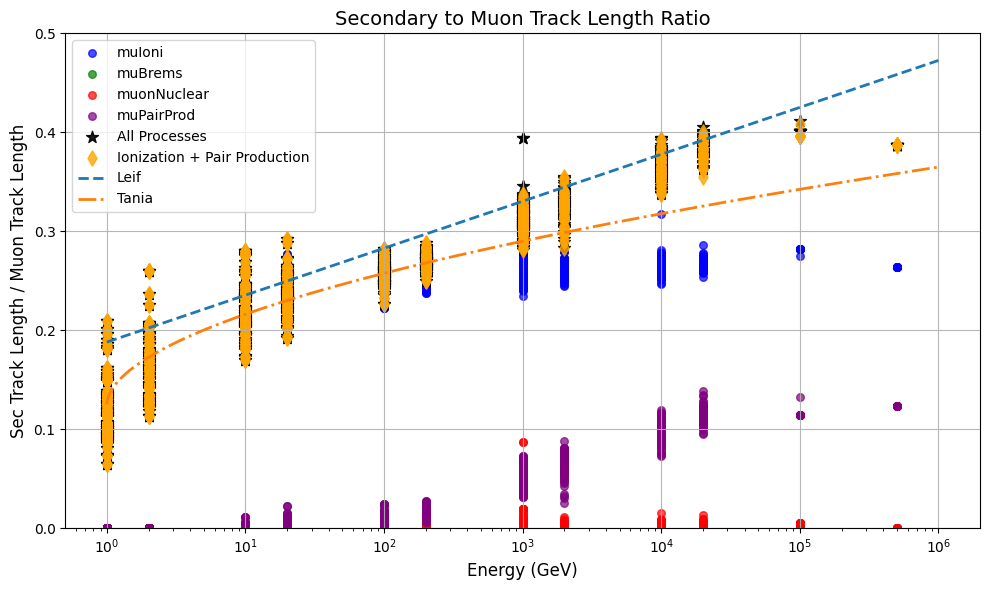

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate the ratio of interest for each process
dfs['all']['track_length_ratio'] = dfs['all']['sum_of_sec_track_lengths_with_FT_correction [m]'] / dfs['all']['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = dfs['all'][dfs['all']['process'] == process]
    plt.scatter(
        process_data['energy_value'],  # x-axis: energy
        process_data['track_length_ratio'],  # y-axis: the ratio
        c=color,
        label=process,
        alpha=0.7,
        s=30  # point size
    )

# Create a key to identify unique events
dfs['all']['event_key'] = dfs['all']['directory'] + '_' + dfs['all']['event_id'].astype(str)

# Create a DataFrame only for muIoni and muPairProd
ioni_and_pair_df = dfs['all'][dfs['all']['process'].isin(['muIoni', 'muPairProd'])]

# Group by energy value and event key to get sums of the track lengths for only these two processes
sum_ft_ioni_pair = ioni_and_pair_df.groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event
muon_lengths = dfs['all'].groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_ioni_pair = pd.merge(sum_ft_ioni_pair, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the ratio for ionization + pair production
merged_ioni_pair['combined_ratio'] = merged_ioni_pair['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_ioni_pair['muon_track_length [m]']

# Print max ratio for verification
print(f"Maximum ioni+pair ratio: {np.max(merged_ioni_pair['combined_ratio'])}")

# Plot the original sum of all processes as black stars
all_processes_df = dfs['all'].copy()
sum_ft_all = all_processes_df.groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()
merged_all = pd.merge(sum_ft_all, muon_lengths, on=['energy_value', 'event_key'])
merged_all['total_ratio'] = merged_all['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_all['muon_track_length [m]']

plt.scatter(
    merged_all['energy_value'],
    merged_all['total_ratio'],
    c='black',
    label='All Processes',
    marker='*',
    alpha=0.9,
    s=80
)

# Plot the ionization + pair production sum as yellow diamonds
plt.scatter(
    merged_ioni_pair['energy_value'],
    merged_ioni_pair['combined_ratio'],
    c='orange',
    label='Ionization + Pair Production',
    marker='d',  # diamond marker
    alpha=0.8,
    s=60
)

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='Leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='Tania', linewidth=2, linestyle='-.')

# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.ylim(0, 0.5)  # Set y-axis limits as requested
plt.legend()
plt.grid(True, alpha=0.9)

plt.tight_layout()
plt.show()

## filtering out events with propagation distance less than 1000 meters: 

In [19]:
merged_data.iloc[567]

energy_value                                                                                     10
event_key                                          out_10GeV_10m_prop_icesim_E10000_10.0_GeV.root_7
sum_of_sec_track_lengths_with_FT_correction [m]                                           11.092977
muon_track_length [m]                                                                     46.910315
total_ratio                                                                                0.236472
Name: 567, dtype: object

/tmp/ipykernel_979054/4211611885.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_length_ratio'] = filtered_df['sum_of_sec_track_lengths_with_FT_correction [m]'] / filtered_df['muon_track_length [m]']
/tmp/ipykernel_979054/4211611885.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['event_key'] = filtered_df['directory'] + '_' + filtered_df['event_id'].astype(str)


Maximum total ratio: 1.0055786302454128 at index: 1967
Number of events with track length < 11m: 2072


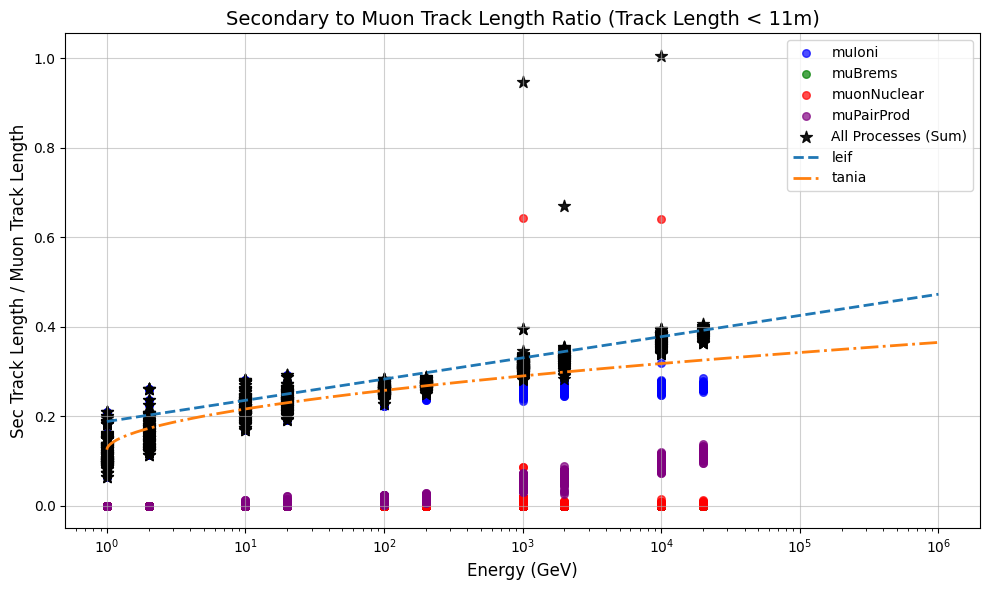

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter for events with muon track length less than 11 meters
#filtered_df = dfs['all'][dfs['all']['muon_track_length [m]'] > 1100]
filtered_df = dfs['all'][dfs['all']['muon_kinetic_energy [GeV]'] < 1e5]

# Calculate the ratio of interest for each process
filtered_df['track_length_ratio'] = filtered_df['sum_of_sec_track_lengths_with_FT_correction [m]'] / filtered_df['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = filtered_df[filtered_df['process'] == process]
    if not process_data.empty:
        plt.scatter(
            process_data['energy_value'],  # x-axis: energy
            process_data['track_length_ratio'],  # y-axis: the ratio
            c=color,
            label=process,
            alpha=0.7,
            s=30  # point size
        )

# Create a key to identify unique events
filtered_df['event_key'] = filtered_df['directory'] + '_' + filtered_df['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = filtered_df.groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = filtered_df.groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
if not merged_data.empty:
    print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} at index: {np.argmax(merged_data['total_ratio'])}")
    print(f"Number of events with track length < 11m: {len(merged_data)}")

# Plot the sum as a fifth type of point
if not merged_data.empty:
    plt.scatter(
        merged_data['energy_value'],
        merged_data['total_ratio'],
        c='black',
        label='All Processes (Sum)',
        marker='*',
        alpha=0.9,
        s=80  # Larger size for visibility
    )

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')

# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (Track Length < 11m)', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.6)

plt.tight_layout()
plt.show()

Maximum total ratio: 1.0055786302454128 at index: 1967
Number of events with track length < 11m: 2092


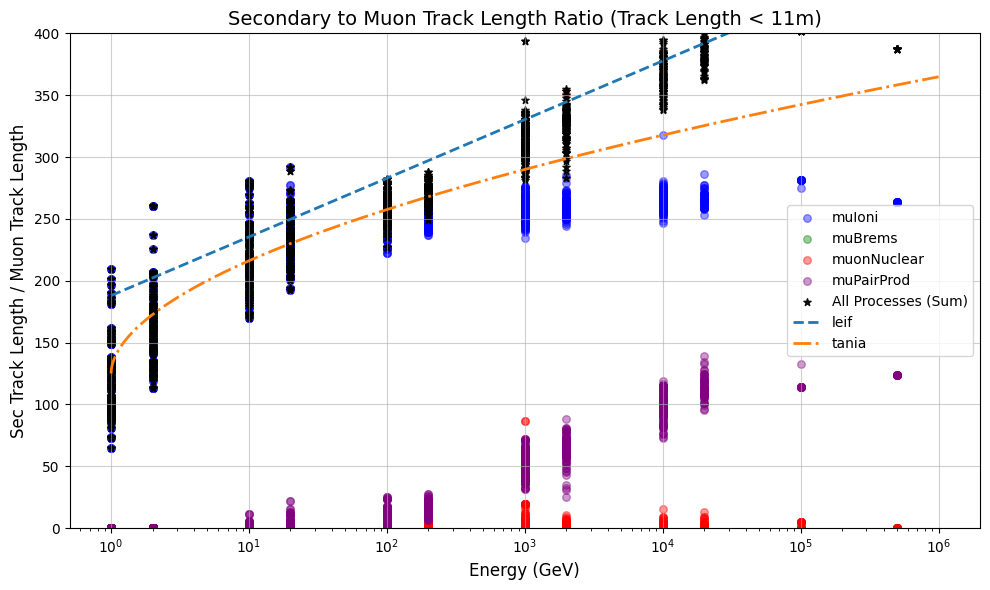

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter for events with muon track length less than 11 meters
filtered_df = dfs['all'][dfs['all']['muon_track_length [m]'] > 0]

# Calculate the ratio of interest for each process
filtered_df['track_length_ratio'] = filtered_df['sum_of_sec_track_lengths_with_FT_correction [m]'] / filtered_df['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = filtered_df[filtered_df['process'] == process]
    if not process_data.empty:
        plt.scatter(
            process_data['energy_value'],  # x-axis: energy
            process_data['track_length_ratio']*1000,  # y-axis: the ratio
            c=color,
            label=process,
            alpha=0.4,
            s=30  # point size
        )

# Create a key to identify unique events
filtered_df['event_key'] = filtered_df['directory'] + '_' + filtered_df['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = filtered_df.groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = filtered_df.groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
if not merged_data.empty:
    print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} at index: {np.argmax(merged_data['total_ratio'])}")
    print(f"Number of events with track length < 11m: {len(merged_data)}")

# Plot the sum as a fifth type of point
if not merged_data.empty:
    plt.scatter(
        merged_data['energy_value'],
        merged_data['total_ratio']*1000,
        c='black',
        label='All Processes (Sum)',
        marker='*',
        alpha=0.9,
        s=30  # Larger size for visibility
    )

# Add model lines
def model1(E):
    return 1000*(np.log(E) * 0.0206 + 0.188)

def model2(E):
    return 1000*((np.log(E))**0.54 * 0.0581 + 0.125)

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')
plt.ylim(0, 400)
# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (Track Length < 11m)', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.6)

plt.tight_layout()
plt.show()

## now only abonve 11meters:

In [18]:
(270+0.14318099821251348+0.2481863876902617+93.75086062349035)/100

3.641422280093932

In [19]:
dfs['all'].columns

Index(['sum_of_sec_track_lengths_without_FT_correction [m]',
       'sum_of_sec_track_lengths_with_FT_correction [m]',
       'sum_of_sec_kin_energies [GeV]', 'muon_kinetic_energy [GeV]',
       'muon_track_length [m]', 'num_photons_lowE_sec', 'num_photons_muon',
       'total_num_photons', 'event_id', 'process', 'energy', 'directory',
       'source_file', 'energy_value', 'track_length_ratio', 'event_key'],
      dtype='object')

Text(0.5, 0, 'muon track length(m)')

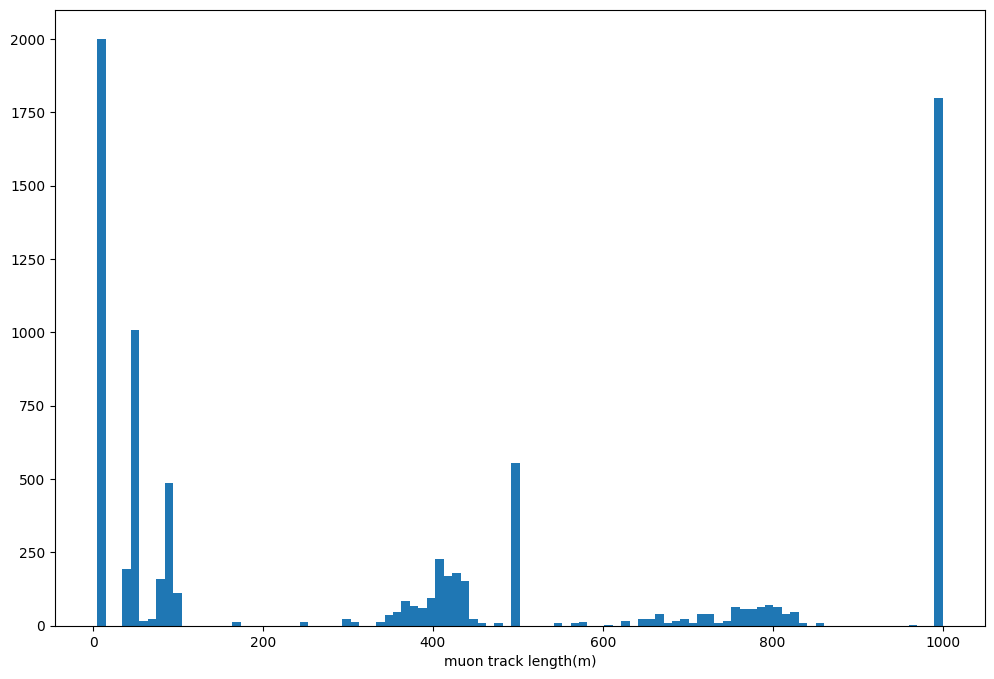

In [20]:
plt.figure(figsize=(12,8))
plt.hist(dfs['all']['muon_track_length [m]'], bins = 100)
plt.xlabel('muon track length(m)')

/tmp/ipykernel_4132927/2655207330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_length_ratio'] = filtered_df['sum_of_sec_track_lengths_with_FT_correction [m]'] / filtered_df['muon_track_length [m]']
/tmp/ipykernel_4132927/2655207330.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['event_key'] = filtered_df['directory'] + '_' + filtered_df['event_id'].astype(str)


Maximum total ratio: 1.0055786302454128 at index: 1467
Number of events with track length < 11m: 1592


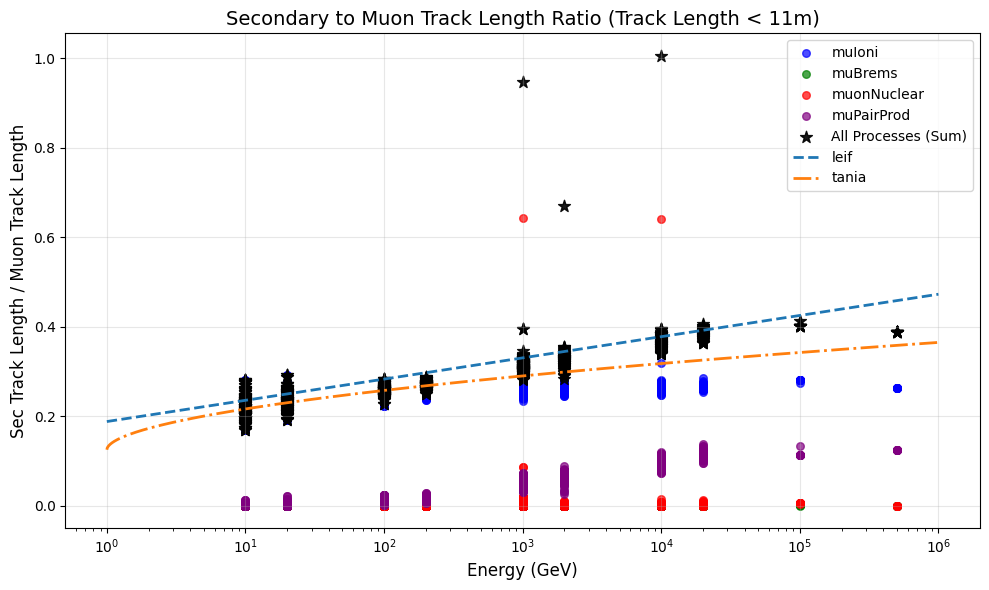

In [21]:
filtered_df = dfs['all'][dfs['all']['muon_track_length [m]'] >11]



# Calculate the ratio of interest for each process
filtered_df['track_length_ratio'] = filtered_df['sum_of_sec_track_lengths_with_FT_correction [m]'] / filtered_df['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = filtered_df[filtered_df['process'] == process]
    if not process_data.empty:
        plt.scatter(
            process_data['energy_value'],  # x-axis: energy
            process_data['track_length_ratio'],  # y-axis: the ratio
            c=color,
            label=process,
            alpha=0.7,
            s=30  # point size
        )

# Create a key to identify unique events
filtered_df['event_key'] = filtered_df['directory'] + '_' + filtered_df['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = filtered_df.groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = filtered_df.groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
if not merged_data.empty:
    print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} at index: {np.argmax(merged_data['total_ratio'])}")
    print(f"Number of events with track length < 11m: {len(merged_data)}")

# Plot the sum as a fifth type of point
if not merged_data.empty:
    plt.scatter(
        merged_data['energy_value'],
        merged_data['total_ratio'],
        c='black',
        label='All Processes (Sum)',
        marker='*',
        alpha=0.9,
        s=80  # Larger size for visibility
    )

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')

# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (Track Length < 11m)', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_4132927/1928476844.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['track_length_ratio'] = filtered_df['sum_of_sec_track_lengths_with_FT_correction [m]'] / filtered_df['muon_track_length [m]']
/tmp/ipykernel_4132927/1928476844.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['event_key'] = filtered_df['directory'] + '_' + filtered_df['event_id'].astype(str)


Maximum total ratio: 0.26032451073749757 at index: 303
Number of events with track length < 11m: 500


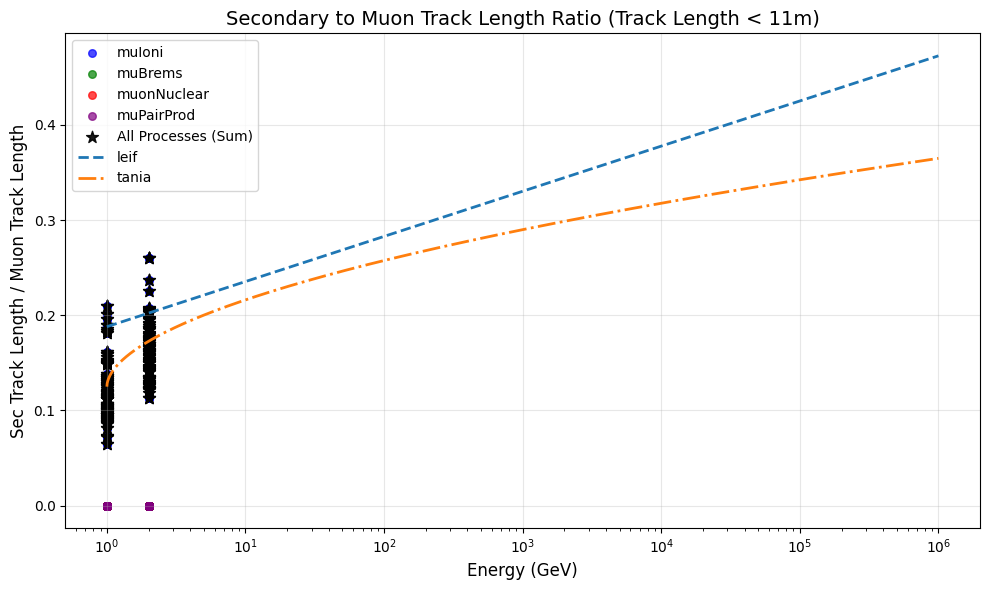

In [22]:
filtered_df = dfs['all'][dfs['all']['muon_track_length [m]'] <11]



# Calculate the ratio of interest for each process
filtered_df['track_length_ratio'] = filtered_df['sum_of_sec_track_lengths_with_FT_correction [m]'] / filtered_df['muon_track_length [m]']

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each process type
colors = {
    'muIoni': 'blue',
    'muBrems': 'green',
    'muonNuclear': 'red',
    'muPairProd': 'purple'
}

# Plot each process as a different color
for process, color in colors.items():
    process_data = filtered_df[filtered_df['process'] == process]
    if not process_data.empty:
        plt.scatter(
            process_data['energy_value'],  # x-axis: energy
            process_data['track_length_ratio'],  # y-axis: the ratio
            c=color,
            label=process,
            alpha=0.7,
            s=30  # point size
        )

# Create a key to identify unique events
filtered_df['event_key'] = filtered_df['directory'] + '_' + filtered_df['event_id'].astype(str)

# Group by energy value and event key to get sums of the original track lengths
sum_ft_correction = filtered_df.groupby(['energy_value', 'event_key'])['sum_of_sec_track_lengths_with_FT_correction [m]'].sum().reset_index()

# Get muon track length for each event (it should be the same for all processes in the same event)
muon_lengths = filtered_df.groupby(['energy_value', 'event_key'])['muon_track_length [m]'].first().reset_index()

# Merge the two dataframes
merged_data = pd.merge(sum_ft_correction, muon_lengths, on=['energy_value', 'event_key'])

# Calculate the proper ratio
merged_data['total_ratio'] = merged_data['sum_of_sec_track_lengths_with_FT_correction [m]'] / merged_data['muon_track_length [m]']

# Print max ratio for verification
if not merged_data.empty:
    print(f"Maximum total ratio: {np.max(merged_data['total_ratio'])} at index: {np.argmax(merged_data['total_ratio'])}")
    print(f"Number of events with track length < 11m: {len(merged_data)}")

# Plot the sum as a fifth type of point
if not merged_data.empty:
    plt.scatter(
        merged_data['energy_value'],
        merged_data['total_ratio'],
        c='black',
        label='All Processes (Sum)',
        marker='*',
        alpha=0.9,
        s=80  # Larger size for visibility
    )

# Add model lines
def model1(E):
    return np.log(E) * 0.0206 + 0.188

def model2(E):
    return (np.log(E))**0.54 * 0.0581 + 0.125

energies = np.logspace(np.log10(1), np.log10(1e6), 5000)

model1_values = np.array([model1(E) for E in energies])
model2_values = np.array([model2(E) for E in energies])

plt.plot(energies, model1_values, label='leif', linewidth=2, linestyle='--')
plt.plot(energies, model2_values, label='tania', linewidth=2, linestyle='-.')

# Add labels and legend
plt.xlabel('Energy (GeV)', fontsize=12)
plt.ylabel('Sec Track Length / Muon Track Length', fontsize=12)
plt.title('Secondary to Muon Track Length Ratio (Track Length < 11m)', fontsize=14)
plt.xscale('log')  # log scale for energy
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()